## Group No: 53

## Group Member Names:
| Name          | BITS ID       | Contribution |
|---------------|---------------|--------------|
| Mujtaba Rasool| 2023ac05819   | 100%         |
| Kartik Batta  | 2023ac05422   | 100%         |
| Sachin Laddha | 2023ac05564   | 100%         |

1.**Problem statement**: 

* Develop a reinforcement learning agent using dynamic programming to solve the Treasure Hunt problem in a FrozenLake environment. The agent must learn the optimal policy for navigating the lake while avoiding holes and maximizing its treasure collection.

2.**Scenario**:
* A treasure hunter is navigating a slippery 5x5 FrozenLake grid. The objective is to navigate through the lake collecting treasures while avoiding holes and ultimately reaching the exit (goal).
Grid positions on a 5x5 map with tiles labeled as S, F, H, G, T. The state includes the current position of the agent and whether treasures have been collected. 


#### Objective
* The agent must learn the optimal policy π* using dynamic programming to maximize its cumulative reward while navigating the lake.

#### About the environment

The environment consists of several types of tiles:
* Start (S): The initial position of the agent, safe to step.
* Frozen Tiles (F): Frozen surface, safe to step.
* Hole (H): Falling into a hole ends the game immediately (die, end).
* Goal (G): Exit point; reaching here ends the game successfully (safe, end).
* Treasure Tiles (T): Added to the environment. Stepping on these tiles awards +5 reward but does not end the game. 

After stepping on a treasure tile, it becomes a frozen tile (F).
The agent earns rewards as follows:
* Reaching the goal (G): +10 reward.
* Falling into a hole (H): -10 reward.
* Collecting a treasure (T): +5 reward.
* Stepping on a frozen tile (F): 0 reward.

#### States
* Current position of the agent (row, column).
* A boolean flag (or equivalent) for whether each treasure has been collected.

#### Actions
* Four possible moves: up, down, left, right

#### Rewards
* Goal (G): +10.
* Treasure (T): +5 per treasure.
* Hole (H): -10.
* Frozen tiles (F): 0.

#### Environment
Modify the FrozenLake environment in OpenAI Gym to include treasures (T) at certain positions. Inherit the original FrozenLakeEnv and modify the reset and step methods accordingly.
Example grid:

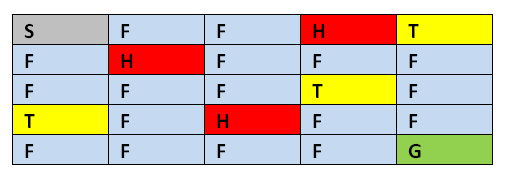


**Expected Outcomes:**
1.	Create the custom environment by modifying the existing “FrozenLakeNotSlippery-v0” in OpenAI Gym and Implement the dynamic programming using value iteration and policy improvement to learn the optimal policy for the Treasure Hunt problem.
2.	Calculate the state-value function (V*) for each state on the map after learning the optimal policy.
3.	Compare the agent’s performance with and without treasures, discussing the trade-offs in reward maximization.
4.	Visualize the agent’s direction on the map using the learned policy.
5.	Calculate expected total reward over multiple episodes to evaluate performance.

### Import required libraries and Define the custom environment - 2 Marks

In [1]:
pip install gym numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import statements
import gym
from gym.envs.toy_text import FrozenLakeEnv
import numpy as np

In [3]:
# Custom environment to create the given grid and respective functions that are required for the problem

#Include functions to take an action, get reward, to check if episode is over
class FrozenLakeTreasureEnv(FrozenLakeEnv):
    def __init__(self):
        super().__init__(desc=np.asarray([
            [b'S', b'F', b'F', b'H', b'T'],
            [b'F', b'H', b'F', b'F', b'F'],
            [b'F', b'F', b'F', b'T', b'F'],
            [b'T', b'F', b'H', b'F', b'F'],
            [b'F', b'F', b'F', b'F', b'G']
        ], dtype='|S1'), is_slippery=False)

        self.treasure_locations = [(0, 4), (2, 3), (3, 0)]
        self.treasures_collected = set()

        self.nS = self.observation_space.n
        self.nA = self.action_space.n
        self.ncol = 5

    def reset(self):
        self.s = 0
        self.treasures_collected = set()
        return self.s

    def step(self, a):
        self.lastaction = a
        curr_pos = (self.s // self.ncol, self.s % self.ncol)
        next_state = self._move(self.s, a)
        next_pos = (next_state // self.ncol, next_state % self.ncol)

        reward = 0
        done = False
        next_tile = self.desc[next_pos[0]][next_pos[1]]
        if next_tile == b'G':
            reward = 10
            done = True
        elif next_tile == b'H':
            reward = -10
            done = True
        elif next_tile == b'F':
            reward = 0

        if next_pos in self.treasure_locations and next_pos not in self.treasures_collected:
            reward += 5
            self.treasures_collected.add(next_pos)
            self._update_desc()

        self.s = next_state
        return next_state, reward, done, {}

    def _move(self, state, action):
        row = state // self.ncol
        col = state % self.ncol

        if action == 0:  # left
            col = max(col - 1, 0)
        elif action == 1:  # down
            row = min(row + 1, self.ncol - 1)
        elif action == 2:  # right
            col = min(col + 1, self.ncol - 1)
        elif action == 3:  # up
            row = max(row - 1, 0)

        return row * self.ncol + col

    def _update_desc(self):
        desc = self.desc.tolist()
        for treasure in self.treasures_collected:
            row, col = treasure
            desc[row][col] = b'F'
        self.desc = np.asarray(desc, dtype='|S1')

### Value Iteration Algorithm - 1 Mark

In [4]:
def value_iteration(env, gamma=0.9, theta=1e-8):
    V = np.zeros(env.observation_space.n)
    policy = np.zeros(env.observation_space.n, dtype=int)

    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v = V[s]
            action_values = np.zeros(env.action_space.n)
            actions = env.P[s]  # Use environment's transition probabilities
            for a in range(env.action_space.n):
                action_value = 0
                for prob, next_state, reward, done in actions[a]:
                    row, col = next_state // env.ncol, next_state % env.ncol
                    tile = env.desc[row][col]

                    if tile == b'G':
                        reward = 10
                    elif tile == b'H':
                        reward = -10
                    elif tile == b'T':
                        reward = 5
                    else:  # Frozen tile
                        reward = 0

                    action_value += prob * (reward + gamma * V[next_state])
                action_values[a] = action_value

            best_action = np.argmax(action_values)
            V[s] = action_values[best_action]
            policy[s] = best_action
            delta = max(delta, np.abs(v - V[s]))
        if delta < theta:
            break
    return V, policy

### Policy Improvement Function - 1 Mark

### Print the Optimal Value Function

In [5]:
def print_value_function(V, env):
    print("\nOptimal Value Function:")
    map_size = int(np.sqrt(env.observation_space.n))
    for i in range(map_size):
        for j in range(map_size):
            print("{:6.2f}".format(V[i * map_size + j]), end=" ")
        print()

### Visualization of the learned optimal policy - 1 Mark

In [6]:
def visualize_policy(policy, map_size):
    actions = ["←", "↓", "→", "↑"]
    policy_grid = policy.reshape(map_size, map_size)
    print("\nOptimal Policy:")
    for row in policy_grid:
        print(" ".join([actions[action] for action in row]))

### Evaluate the policy - 1 Mark

In [7]:
def evaluate_policy(env, policy, num_episodes=100):
    total_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        total_reward = 0
        done = False
        while not done:
            action = policy[int(state)]
            step_result = env.step(action)

            if len(step_result) == 5:
                next_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_result

            if isinstance(next_state, tuple):
                next_state = next_state[0]

            total_reward += reward
            state = next_state
        total_rewards.append(total_reward)
    return np.mean(total_rewards)

### Main Execution

In [8]:
    # Create environment with treasures
    env = FrozenLakeTreasureEnv()

    # Run value iteration
    V, policy = value_iteration(env)

    # Print results for environment with treasures
    print("\n=== Environment With Treasures ===")
    print_value_function(V, env)
    visualize_policy(policy, 5)
    reward_with_treasures = evaluate_policy(env, policy)
    print("\nAverage Reward with Treasures:", reward_with_treasures)

    # Create environment without treasures
    env_no_treasures = FrozenLakeEnv(desc=np.asarray([
        [b'S', b'F', b'F', b'H', b'F'],
        [b'F', b'H', b'F', b'F', b'F'],
        [b'F', b'F', b'F', b'F', b'F'],
        [b'F', b'F', b'H', b'F', b'F'],
        [b'F', b'F', b'F', b'F', b'G']
    ], dtype='|S1'), is_slippery=False)

    # Run value iteration for environment without treasures
    V_no_treasures, policy_no_treasures = value_iteration(env_no_treasures)

    # Print results for environment without treasures
    print("\n=== Environment Without Treasures ===")
    print_value_function(V_no_treasures, env_no_treasures)
    visualize_policy(policy_no_treasures, 5)
    reward_no_treasures = evaluate_policy(env_no_treasures, policy_no_treasures)
    print("\nAverage Reward without Treasures:", reward_no_treasures)


=== Environment With Treasures ===

Optimal Value Function:
 51.88  56.79  63.10 -100.00  72.90 
 57.64 -100.00  70.11  77.90  81.00 
 64.05  70.11  77.90  81.00  90.00 
 65.61  72.90 -100.00  90.00 100.00 
 72.90  81.00  90.00 100.00 100.00 

Optimal Policy:
↓ → ↓ ← ↓
↓ ← ↓ ↓ ↓
↓ → → ↓ ↓
↓ ↓ ← ↓ ↓
→ → → → ←

Average Reward with Treasures: 15.0

=== Environment Without Treasures ===

Optimal Value Function:
 47.83  53.14  59.05 -100.00  72.90 
 53.14 -100.00  65.61  72.90  81.00 
 59.05  65.61  72.90  81.00  90.00 
 65.61  72.90 -100.00  90.00 100.00 
 72.90  81.00  90.00 100.00 100.00 

Optimal Policy:
↓ → ↓ ← ↓
↓ ← ↓ ↓ ↓
↓ ↓ → ↓ ↓
↓ ↓ ← ↓ ↓
→ → → → ←

Average Reward without Treasures: 1.0
